## Dataset cleaning and preprocessing

In [1]:
from pathlib import Path

import pandas as pd
from ast import literal_eval
import seaborn as sns
import tabulate

from typing import List, Tuple, Dict, Optional

In [2]:
from IPython.core.display import display, HTML

# display(HTML("<style>.container { width:100% !important; }</style>"))

# Show all columns and everything inside it
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

# Suppress scientific notation etc.
pd.set_option("display.precision", 3)
pd.options.display.float_format = "{:,.3f}".format

/tmp/ipykernel_840873/2996481412.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
%load_ext jupyter_black

In [4]:
# Path to merged CSV containing PDF+spacy+ld stats
CSV_PATH = Path("../data/merge_res.csv")

# Path to the txt corpus (used for UTF8-garbage detection later)
DS_TXT = Path("/home/sh/hsa/papers/dataset/flattened/FULL_CLI")

# csv file with known bad docs to exclude from the very beginning
BAD_DOCS_PATH = Path("../data/known_bad_docs.csv")

In [5]:
# CSV file with additional PDF-only part of the dataset, w/o corresponding text files
PDF_CSV_ADDITIONAL = Path("../data/remaining_BB_monthly_2023-10-16T18:43.csv")

In [6]:
def print_full(x):
    pd.set_option("display.max_rows", None)
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", 2000)
    pd.set_option("display.float_format", "{:20,.2f}".format)
    pd.set_option("display.max_colwidth", None)
    display(x)
    pd.reset_option("display.max_rows")
    pd.reset_option("display.max_columns")
    pd.reset_option("display.width")
    pd.reset_option("display.float_format")
    pd.reset_option("display.max_colwidth")

In [7]:
df = pd.read_csv(CSV_PATH)
# Drop old columns with errors, there should be none there
# df.drop(columns=["error", "exception_text"], inplace=True)
df.head()

,doc_path,num_pages,metadata,txt_file,source_fn,txt_fn,collection,num_chars,num_tokens,num_sentences,langs_raw,langs_small
0,/home/sh/hsa/papers/dataset/extracted/Final_terms/Country_of_origin_DE/lang_DE_EN/DE000HLB7C13.pdf,19.000,"{'format': 'PDF 1.4', 'title': 'EA', 'author': 'Helaba', 'subject': '', 'keywords': '', 'creator': 'Structured Products Database (SPD)', 'producer': '3-Heights(TM) PDF Producer 4.4.43.1 (http://www.pdf-tools.com)', 'creationDate': ""D:20221229153146+01'00'"", 'modDate': ""D:20230106125609+01'00'"", 'trapped': '', 'encryption': None}",/tmp/FULL_CLI/Final_terms/DE000HLB7C13.pdf.txt,Final_terms/Country_of_origin_DE/lang_DE_EN/DE000HLB7C13.pdf,Final_terms/DE000HLB7C13.pdf.txt,Final_terms,"54,319.000","8,365.000",340.000,"Counter({'GERMAN': 0.9822987680899414, 'PORTUGUESE': 0.004903719650759478, 'DUTCH': 0.004066499222581031, 'FRENCH': 0.003588087549336204, 'ENGLISH': 0.0028704700394689632, 'NYNORSK': 0.001076426264800861, 'SPANISH': 0.0008372204281784475, 'ITALIAN': 0.0003588087549336204})","{'GERMAN': 0.9873767732628036, 'PORTUGUESE': 0.004929069487857658, 'DUTCH': 0.004087521038711229, 'FRENCH': 0.0036066362106275548}"
1,/home/sh/hsa/papers/dataset/extracted/Final_terms/Country_of_origin_DE/lang_DE_EN/DE000NWB2ME7.pdf,14.000,"{'format': 'PDF 1.6', 'title': '', 'author': 'Schulz, Hartmut', 'subject': '', 'keywords': '', 'creator': 'Microsoft® Word 2016', 'producer': 'Microsoft® Word 2016', 'creationDate': ""D:20200513175357+02'00'"", 'modDate': ""D:20200526104335+02'00'"", 'trapped': '', 'encryption': None}",/tmp/FULL_CLI/Final_terms/DE000NWB2ME7.pdf.txt,Final_terms/Country_of_origin_DE/lang_DE_EN/DE000NWB2ME7.pdf,Final_terms/DE000NWB2ME7.pdf.txt,Final_terms,"23,605.000","4,354.000",183.000,"Counter({'ENGLISH': 0.45957740009186954, 'GERMAN': 0.45728066146072577, 'FRENCH': 0.02939825447864033, 'PORTUGUESE': 0.01515847496554892, 'DUTCH': 0.0133210840606339, 'SPANISH': 0.010794671566375747, 'NYNORSK': 0.009875976113918236, 'ITALIAN': 0.004593477262287551})","{'ENGLISH': 0.47802197802197804, 'GERMAN': 0.4756330625895843, 'FRENCH': 0.030578117534639272, 'PORTUGUESE': 0.015766841853798376}"
2,/home/sh/hsa/papers/dataset/extracted/Final_terms/Country_of_origin_DE/lang_DE_EN/DE000DFK0TS8.pdf,25.000,"{'format': 'PDF 1.5', 'title': '', 'author': 'Heimann, Rolf', 'subject': '', 'keywords': '', 'creator': 'Microsoft® Word 2016', 'producer': 'Microsoft® Word 2016', 'creationDate': ""D:20220701165246+02'00'"", 'modDate': ""D:20220701165246+02'00'"", 'trapped': '', 'encryption': None}",/tmp/FULL_CLI/Final_terms/DE000DFK0TS8.pdf.txt,Final_terms/Country_of_origin_DE/lang_DE_EN/DE000DFK0TS8.pdf,Final_terms/DE000DFK0TS8.pdf.txt,Final_terms,"70,180.000","12,733.000",748.000,"Counter({'GERMAN': 0.4806122448979592, 'ENGLISH': 0.45062794348508634, 'FRENCH': 0.029199372056514912, 'NYNORSK': 0.011695447409733124, 'ITALIAN': 0.00816326530612245, 'PORTUGUESE': 0.0076138147566719, 'DUTCH': 0.006828885400313972, 'SPANISH': 0.0052590266875981164})","{'GERMAN': 0.4943883730318934, 'ENGLISH': 0.4635446104158256, 'FRENCH': 0.030036334275333063, 'NYNORSK': 0.01203068227694792}"
3,/home/sh/hsa/papers/dataset/extracted/Final_terms/Country_of_origin_DE/lang_DE_EN/DE000LB2CZ54.pdf,15.000,"{'format': 'PDF 1.4', 'title': 'Dokumentation', 'author': 'Landesbank Baden-Württemberg', 'subject': '', 'keywords': '', 'creator': 'Microsoft Word - IHS_fix_100.000_MREL_NonPref_2020_Final.docx', 'producer': 'eDocPrinter PDF Pro (W12R2Svr x64) Ver 6.96 Build 6379-6365', 'creationDate': ""D:20210324100114+01'00'"", 'modDate': ""D:20210329092238+02'00'"", 'trapped': '', 'encryption': None}",/tmp/FULL_CLI/Final_terms/DE000LB2CZ54.pdf.txt,Final_terms/Country_of_origin_DE/lang_DE_EN/DE000LB2CZ54.pdf,Final_terms/DE000LB2CZ54.pdf.txt,Final_terms,"46,594.000","7,544.000",291.000,"Counter({'GERMAN': 0.976004242343895, 'ENGLISH': 0.010738432984223783, 'PORTUGUESE': 0.006893808829378231, 'DUTCH': 0.0023863184409386186, 'FRENCH': 0.0022537451942198066, 'NYNORSK': 0.

In [8]:
RENAMES = {
    "Final_terms": "Final_terms",
    "Law": "Law",
    "Brochures_and_InfoMaterials": "Informational_materials",
    # "Brochures_and_InfoMaterials": "Brochures & Handouts",
    # "Brochures_and_InfoMaterials": "Brochures",
    "Monthly_reports_BB": "BBK_monthly",
    "Annual_reports": "Annual_reports",
    "Basisprospekte": "Base_prospectuses",
    "IFRS": "IFRS",
}

df["collection"] = df["collection"].apply(lambda x: RENAMES[x])

In [9]:
# Column names we'll be using often
KEY_MONTHLY = "BBK_monthly"
KEY_FT = "Final_terms"

### Delete known-bad documents

In [10]:
bad_docs_df = pd.read_csv(BAD_DOCS_PATH, sep="\t")
bd_list = list(bad_docs_df.txt_fn)
bd_rows = df[df.txt_fn.isin(bd_list)]

missing = set(bd_list).difference(set(bd_rows.txt_fn))
if missing:
    print(f"!! Known-bad docs missing:\n{missing}")
df = df.drop(labels=bd_rows.index).reset_index(drop=True)
print(f"{len(bd_rows)} deleted, {len(df)} docs left")

5 deleted, 12417 docs left


### Keep docs we want to include as PDF-only (that is without spacy stats) out

In [11]:
print(len(df))
df_kept_out = df[df.num_chars.isna()]
df.drop(labels=df[df.num_chars.isna()].index, inplace=True)
print(len(df))

12417
12417


In [12]:
df.describe()

,num_pages,num_chars,num_tokens,num_sentences
count,"12,417.000","12,417.000","12,417.000","12,417.000"
mean,36.974,"112,054.600","22,174.862",793.466
std,78.215,"260,278.215","53,197.157","1,944.868"
min,1.000,11.000,4.000,1.000
25%,13.000,"27,231.000","4,773.000",220.000
50%,21.000,"57,637.000","9,401.000",349.000
75%,35.000,"90,523.000","15,798.000",659.000
max,"1,861.000","6,821,524.000","1,363,872.000","44,046.000"


In [13]:
INT_COLS = ["num_pages", "num_chars", "num_tokens", "num_sentences"]
df[INT_COLS] = df[INT_COLS].astype(
    int, errors="ignore"
)  # The BBK Monthly reports have NaN

## Stats and language detection

In [14]:
df["token_len"] = df["num_chars"] / df["num_tokens"]
df["sentence_len"] = df["num_tokens"] / df["num_sentences"]
df["tokens_per_page"] = df["num_tokens"] / df["num_pages"]

In [15]:
# Drop the pdf with scrambled text that has no lang-det output creating an ast exception in eval
df.drop(
    df[df.txt_fn == "Final_terms/DE000A289YV5.pdf.txt"].index,
    inplace=True,
)

In [16]:
# Parse the Counter thing by transforming it into a vanilla dictionary add as columns to dataframe
df["langs_raw_extracted"] = df.langs_raw.str.extract(r"Counter\((.*)\)")
df["langs_list"] = df.langs_raw_extracted.apply(literal_eval)
# pd.json_normalize(df.langs_list)

# dfl contains now all data + new language columns
dfl = df.join(pd.json_normalize(df.langs_list).fillna(0))

In [17]:
# Add English + German probability as column
dfl["EN_DE"] = dfl.ENGLISH + dfl.GERMAN
# The other languages summed together
dfl["OTHER"] = 1 - dfl["EN_DE"]

In [18]:
# Create some interesting shortcuts for column names

# Languages
MAIN_LANG_COLS = ["ENGLISH", "GERMAN"]
OTHER_LANG_COLS = [
    "PORTUGUESE",
    "DUTCH",
    "FRENCH",
    "NYNORSK",
    "SPANISH",
    "ITALIAN",
]
LANG_COLS = OTHER_LANG_COLS + MAIN_LANG_COLS
SPECIAL_LANG_COLS = ["EN_DE", "OTHER"]

# Stats
SPACY_STATS_COLS = ["num_tokens", "num_sentences"]
PDF_STATS_COLS = ["num_pages", "collection"]
STATS_COLS = ["token_len", "sentence_len", "tokens_per_page"]

# Filenames
FN_COLS = ["txt_fn", "source_fn"]

for i in [LANG_COLS, STATS_COLS, SPACY_STATS_COLS, FN_COLS, PDF_STATS_COLS]:
    for c in i:
        assert c in list(dfl.columns), c

INTERESTING_COLS = STATS_COLS + FN_COLS + LANG_COLS

In [19]:
dfl.describe()

,num_pages,num_chars,num_tokens,num_sentences,token_len,sentence_len,tokens_per_page,GERMAN,PORTUGUESE,DUTCH,FRENCH,ENGLISH,NYNORSK,SPANISH,ITALIAN,EN_DE,OTHER
count,"12,417.000","12,417.000","12,417.000","12,417.000","12,417.000","12,417.000","12,417.000","12,417.000","12,417.000","12,417.000","12,417.000","12,417.000","12,417.000","12,417.000","12,417.000","12,417.000","12,417.000"
mean,36.974,"112,054.600","22,174.862",793.466,5.761,28.081,483.846,0.763,0.008,0.013,0.013,0.185,0.008,0.003,0.008,0.947,0.053
std,78.215,"260,278.215","53,197.157","1,944.868",0.707,184.441,232.361,0.285,0.013,0.047,0.018,0.257,0.018,0.011,0.031,0.087,0.087
min,1.000,11.000,4.000,1.000,1.000,3.538,1.167,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,13.000,"27,231.000","4,773.000",220.000,5.414,22.213,376.620,0.497,0.004,0.002,0.002,0.007,0.001,0.000,0.001,0.942,0.015
50%,21.000,"57,637.000","9,401.000",349.000,5.961,25.889,448.000,0.959,0.005,0.004,0.005,0.015,0.003,0.001,0.003,0.974,0.026
75%,35.000,"90,523.000","15,798.000",659.000,6.204,28.229,512.368,0.975,0.009,0.007,0.020,0.444,0.010,0.004,0.007,0.985,0.058
max,"1,861.000","6,821,524.000","1,363,872.000","44,046.000",11.373,"17,646.000","5,238.500",1.000,1.000,0.948,0.427,1.000,1.000,1.000,0.532,1.000,1.000


In [20]:
dfl[INTERESTING_COLS].head()

,token_len,sentence_len,tokens_per_page,txt_fn,source_fn,PORTUGUESE,DUTCH,FRENCH,NYNORSK,SPANISH,ITALIAN,ENGLISH,GERMAN
0,6.494,24.603,440.263,Final_terms/DE000HLB7C13.pdf.txt,Final_terms/Country_of_origin_DE/lang_DE_EN/DE000HLB7C13.pdf,0.005,0.004,0.004,0.001,0.001,0.000,0.003,0.982
1,5.421,23.792,311.000,Final_terms/DE000NWB2ME7.pdf.txt,Final_terms/Country_of_origin_DE/lang_DE_EN/DE000NWB2ME7.pdf,0.015,0.013,0.029,0.010,0.011,0.005,0.460,0.457
2,5.512,17.023,509.320,Final_terms/DE000DFK0TS8.pdf.txt,Final_terms/Country_of_origin_DE/lang_DE_EN/DE000DFK0TS8.pdf,0.008,0.007,0.029,0.012,0.005,0.008,0.451,0.481
3,6.176,25.924,502.933,Final_terms/DE000LB2CZ54.pdf.txt,Final_terms/Country_of_origin_DE/lang_DE_EN/DE000LB2CZ54.pdf,0.007,0.002,0.002,0.001,0.000,0.001,0.011,0.976
4,6.219,27.366,383.120,Final_terms/DE000BLB80W4.pdf.txt,Final_terms/Country_of_origin_DE/lang_DE_EN/DE000BLB80W4.pdf,0.003,0.001,0.002,0.002,0.003,0.006,0.010,0.973


/home/sh/hsa/papers/german-financial-dataset/code/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sh/hsa/papers/german-financial-dataset/code/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sh/hsa/papers/german-financial-dataset/code/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 0, 'Share of non-EN/DE languages in collection')

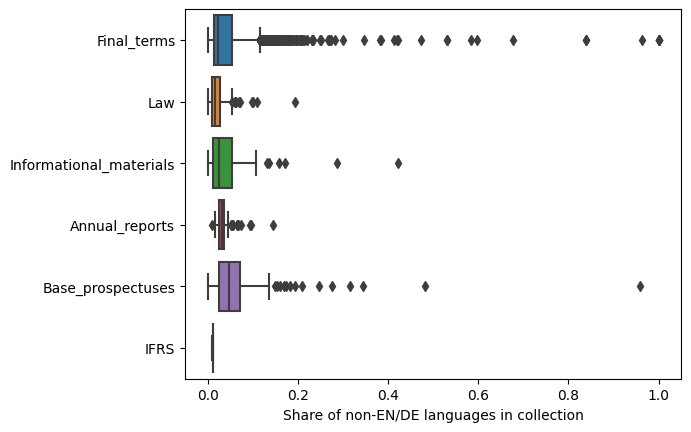

In [21]:
# Visualize documents with high non-EN-DE lang. detection results by collection
# excluding the known-messy BB monthly reports
g = sns.boxplot(dfl[dfl.collection != KEY_MONTHLY], x="OTHER", y="collection")
g.set_ylabel("")
g.set_xlabel("Share of non-EN/DE languages in collection")

## Classes of bad documents
- UTF-8 hell, can be partial
    - look for % of invalid UTF-8 code points
- Incomplete OCR
    - look for # of tokens per page
    - and/or # of sentences per document in total - if it's too small we don't want it regardless
- Bad OCR
    - small # of characters in tokens (like the BBK reports dataset...)?
    - ? 

For all three, docs with
- "weird LD results"
- non-DE/AT countries 
are definitely overrepresented.
    
Steps:
1. Throw away documents that are:
    - non-DE+EN language
    - non-DE/AT ISINs
    - (not here) English-only
2. Calculate and estimate thresholds for
    - "low" number tokens per page (=incomplete OCR)

### UTF-8 Hell

In [22]:
#! Assumes DS_TXT set to the txt collection path


def get_doc_text(doc_path: str | Path) -> str:
    """Get str content of str txt file."""
    doc = Path(doc_path)
    txt = doc.read_text()
    return txt


def count_repl_chars(txt: str, repl_char: str = "\ufffd") -> int:
    """Count number of UTF 'REPLACEMENT CHARACTER' chars in text."""
    return txt.count(repl_char)


def parse_file(file_path, collection_path: Path = DS_TXT) -> int:
    """
    In:
        - txt_fn, the filename of the txt starting from collection root ('Final_terms/...')
        - collection_path: path to the collection txt files location
    Out: int number of replacement characters in file
    """
    doc_full_path = collection_path / file_path
    doc_text = get_doc_text(doc_full_path)
    repl_chars_count = count_repl_chars(doc_text)
    # res = dict()
    # res["repl_chars_count"] = repl_chars_count
    # res["repl_chars_rel"] = repl_chars_count / len(doc_text)
    res = repl_chars_count
    return res

In [23]:
# Count UTF8 garbage in each txt file and calculate their ratio
dfl["num_repl_chars"] = dfl["txt_fn"].apply(parse_file)
dfl["repl_chars_ratio"] = dfl["num_repl_chars"] / dfl["num_chars"]

# Add column name to the stats columns
STATS_COLS.append("repl_chars_ratio")

### Parse countries/ISINs from Final Terms documents

In [24]:
# Get ISIN from filename only of final_terms documents
ISIN_REGEX = r"[A-Z]{2}[0-9A-Z]{10}"
# Do only the documents that have a pure ISIN in the filenames
dfl["ISIN"] = dfl.txt_fn.str.extract(f"Final_terms/({ISIN_REGEX})\.pdf.txt")
dfl["country"] = dfl["ISIN"].str.upper().str.extract(r"(^..)")
dfl.country.value_counts()

country
DE    9583
XS     620
AT     159
BE      15
FR       8
CH       5
PT       4
EU       2
ES       1
AU       1
NO       1
Name: count, dtype: int64

In [25]:
# TODO
if False:
    # Count number of invalid filenames not containing ISINs
    dfl.loc[dfl.collection == KEY_FINAL, "len"] = (
        dfl[dfl.collection == KEY_FINAL].txt_fn.apply(len).sort_values()
    )
    dfl[(dfl.len != 32) & (dfl.collection == KEY_FINAL)].sort_values("len")[
        ["txt_fn", "len"]
    ]
    # dfl.drop("len", axis=1, inplace=True)

## Cleaning up

- Keep documents that:
    - aren't BB monthly reports OR
    - fulfill all 6 conditions outlined AND if applicable are from the right countries (Final Terms)

In [26]:
# Row remains if:
# 1. it's not a BB monthly report
query_mr = f"(collection!='{KEY_MONTHLY}')"

# - AND -

# 2. If all criteria from 2a AND 2b are fulfilled:

# 2a) all conditions wrt. statistics
query_pc = (
    # f"(collection=='{KEY_MONTHLY}') |"
    # "("  # It's a BB report, OR all of the below conditions are met:
    "  (num_sentences>6) &"
    "  (tokens_per_page>100) & "
    "  (repl_chars_ratio<0.05) & "
    "  (EN_DE>0.5) "
    # ")"
)
# 2b) IF it's final reports, it has to be from country DE or AT
query_ft = f"((collection!='{KEY_FT}') | ((collection=='{KEY_FT}') & ((country=='DE') | (country=='AT'))))"  # and if it's a FT doc, it's from DE or AT

# FT without the FT query decreases by 130, with it - by 1284.
query = f"{query_mr} & ({query_pc} & {query_ft})"
# query = f"{query_mr} | ({query_pc} & {query_ft})"
# query = f"{query_mr} | ({query_pc})"  # " & {query_ft})"

# Create column in final metadata, True if no TXT is to be provided for file
dfl["pdf_only"] = ~dfl.eval(query)
dfl.pdf_only.value_counts()

pdf_only
False    10737
True      1680
Name: count, dtype: int64

### Parsing languages, deleting English-only

Concept: 
- we know that we have basically two cases, either English/German or English+German. 
- We also know that most other detections left at this stage are wrong
- -> If it's one big language, use it, otherwise assume it's two and it's English+German
- **we also know that the BBK reports are almost completely in German**

In [27]:
langs_replacements = {"ENGLISH": "EN", "GERMAN": "DE"}


def parse_languages(
    row: pd.Series,
    lang_cols=LANG_COLS,
    threshold: float = 0.8,
    langs_replacements: dict[str, str] = langs_replacements,
):
    """
    Given a row with language columns summing up to 1, parse them into two cases:
    - one language
    - two languages
    and return the language or languages as single or comma-separated list.
    """
    # Get languages from row
    langs = row[lang_cols].astype(float)
    # 2 main ones
    mlangs = list(langs[lang_cols].nlargest(2).items())

    # Most frequent language
    ml_name, ml_perc = mlangs[0]

    if ml_perc > threshold:
        # One language only
        res = langs_replacements[ml_name] if ml_name in langs_replacements else ml_name
    else:
        # res = ",".join(sorted([x[0] for x in mlangs]))
        res = "EN,DE"

    return res

In [28]:
dfl["language"] = dfl.apply(parse_languages, axis=1)
# All BBK reports are in German, but this doesn't matter as later we drop the column regardless
dfl[dfl.collection == KEY_MONTHLY].language = "DE"

/tmp/ipykernel_840873/2987382948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfl[dfl.collection == KEY_MONTHLY].language = "DE"


In [29]:
# We don't care about the non-PDF_only rows, since they will be gone anywaay
# dfl.language.value_counts()
dfl[dfl.pdf_only == False].language.value_counts()

language
DE       7442
EN,DE    3094
EN        201
Name: count, dtype: int64

/home/sh/hsa/papers/german-financial-dataset/code/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sh/hsa/papers/german-financial-dataset/code/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sh/hsa/papers/german-financial-dataset/code/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='count', ylabel='language'>

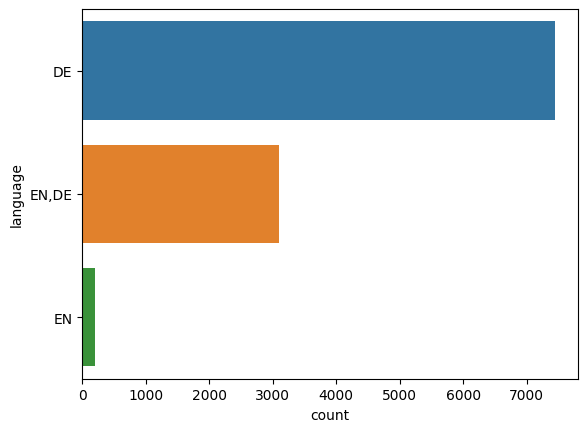

In [30]:
sns.countplot(dfl[dfl.pdf_only == False], y="language")

In [31]:
dfl["delete_completely"] = dfl.language == "EN"
dfl.delete_completely.value_counts()

delete_completely
False    11813
True       604
Name: count, dtype: int64

## Calculating damage

In [32]:
# no_txt is docs missing for whatever of the two reasons
dfl["no_txt"] = dfl["pdf_only"] | dfl["delete_completely"]

In [33]:
# - count = total docs originally
# - sum = docs deleted for this reason
# - mean = % of docs lost for this reason

df_damage = dfl.groupby("collection")[["pdf_only", "delete_completely", "no_txt"]].agg(
    ["count", "sum", "mean"]
)
df_damage

pdf_only             delete_completely             \
                           count   sum  mean             count  sum  mean   
collection                                                                  
Annual_reports                88     1 0.011                88    0 0.000   
BBK_monthly                  412   412 1.000               412    0 0.000   
Base_prospectuses            708     3 0.004               708  115 0.162   
Final_terms                10930  1262 0.115             10930  480 0.044   
IFRS                           7     0 0.000                 7    0 0.000   
Informational_materials      135     2 0.015               135    6 0.044   
Law                          137     0 0.000               137    3 0.022   

                        no_txt              
                         count   sum  mean  
collection                                  
Annual_reports              88     1 0.011  
BBK_monthly                412   412 1.000  
Base_prospectuses          708   118 0.167  
Final_terms              10930  1339 0.123  
IFRS                         7     0 0.000  
Informational_materials    135     8 0.059  
Law                        137     3 0.022

In [34]:
dfl[["pdf_only", "delete_completely", "no_txt"]].agg(["count", "sum", "mean"]).T

,count,sum,mean
pdf_only,"12,417.000","1,680.000",0.135
delete_completely,"12,417.000",604.000,0.049
no_txt,"12,417.000","1,881.000",0.151


## Include the PDF-only part of the dataset

In [35]:
df_pdf_part = pd.read_csv(PDF_CSV_ADDITIONAL)
df_pdf_part["pdf_only"] = True
# Use the renamed collection key
df_pdf_part.collection = KEY_MONTHLY
df_pdf_part

,doc_path,num_pages,metadata,is_empty,txt_file,source_fn,txt_fn,collection,pdf_only
0,/home/sh/hsa/papers/dataset/extracted/ocrd/Monthly_reports_BB/ocr-1999-08-monatsbericht-data.pdf,140,"{'format': 'PDF 1.7', 'title': 'Monatsbericht - August 1999', 'author': '', 'subject': '', 'keywords': '', 'creator': 'ocrmypdf 9.6.0+dfsg / Tesseract OCR-PDF 4.1.1', 'producer': 'pikepdf 1.10.3+dfsg', 'creationDate': ""20001129103228+00'00'"", 'modDate': ""20231005203946+00'00'"", 'trapped': '', 'encryption': None}",False,/tmp/remaining_BB_monthly_docs/Monthly_reports_BB/ocr-1999-08-monatsbericht-data.pdf.txt,Monthly_reports_BB/ocr-1999-08-monatsbericht-data.pdf,Monthly_reports_BB/ocr-1999-08-monatsbericht-data.pdf.txt,BBK_monthly,True
1,/home/sh/hsa/papers/dataset/extracted/ocrd/Monthly_reports_BB/ocr-1978-05-monatsbericht-data.pdf,130,"{'format': 'PDF 1.7', 'title': 'Monatsbericht - Mai 1978', 'author': '', 'subject': '', 'keywords': '', 'creator': 'ocrmypdf 9.6.0+dfsg / Tesseract OCR-PDF 4.1.1', 'producer': 'pikepdf 1.10.3+dfsg', 'creationDate': ""20001017123638+01'00'"", 'modDate': ""20231006041610+00'00'"", 'trapped': '', 'encryption': None}",False,/tmp/remaining_BB_monthly_docs/Monthly_reports_BB/ocr-1978-05-monatsbericht-data.pdf.txt,Monthly_reports_BB/ocr-1978-05-monatsbericht-data.pdf,Monthly_reports_BB/ocr-1978-05-monatsbericht-data.pdf.txt,BBK_monthly,True
2,/home/sh/hsa/papers/dataset/extracted/ocrd/Monthly_reports_BB/ocr-1989-03-monatsbericht-data.pdf,114,"{'format': 'PDF 1.7', 'title': 'Monatsbericht - März 1989', 'author': '', 'subject': '', 'keywords': '', 'creator': 'ocrmypdf 9.6.0+dfsg / Tesseract OCR-PDF 4.1.1', 'producer': 'pikepdf 1.10.3+dfsg', 'creationDate': ""20001122083011+00'00'"", 'modDate': ""20231005210035+00'00'"", 'trapped': '', 'encryption': None}",False,/tmp/remaining_BB_monthly_docs/Monthly_reports_BB/ocr-1989-03-monatsbericht-data.pdf.txt,Monthly_reports_BB/ocr-1989-03-monatsbericht-data.pdf,Monthly_reports_BB/ocr-1989-03-monatsbericht-data.pdf.txt,BBK_monthly,True
3,/home/sh/hsa/papers/dataset/extracted/ocrd/Monthly_reports_BB/ocr-1962-01-monatsbericht-data.pdf,148,"{'format': 'PDF 1.7', 'title': 'Monatsbericht - Januar 1962', 'author': '', 'subject': '', 'keywords': '', 'creator': 'ocrmypdf 9.6.0+dfsg / Tesseract OCR-PDF 4.1.1', 'producer': 'pikepdf 1.10.3+dfsg', 'creationDate': ""20001020153807+01'00'"", 'modDate': ""20231006060213+00'00'"", 'trapped': '', 'encryption': None}",False,/tmp/remaining_BB_monthly_docs/Monthly_reports_BB/ocr-1962-01-monatsbericht-data.pdf.txt,Monthly_reports_BB/ocr-1962-01-monatsbericht-data.pdf,Monthly_reports_BB/ocr-1962-01-monatsbericht-data.pdf.txt,BBK_monthly,True
4,/home/sh/hsa/papers/dataset/extracted/ocrd/Monthly_reports_BB/ocr-1999-02-monatsbericht-data.pdf,158,"{'format': 'PDF 1.7', 'title': 'Monatsbericht - Februar 1999', 'author': '', 'subject': '', 'keywords': '', 'creator': 'ocrmypdf 9.6.0+dfsg / Tesseract OCR-PDF 4.1.1', 'producer': 'pikepdf 1.10.3+dfsg', 'creationDate': ""20001129102315+00'00'"", 'modDate': ""20231006083733+00'00'"", 'trapped': '', 'encryption': None}",False,/tmp/remaining_BB_monthly_docs/Monthly_reports_BB/ocr-1999-02-monatsbericht-data.pdf.txt,Monthly_reports_BB/ocr-1999-02-monatsbericht-data.pdf,Monthly_reports_BB/ocr-1999-02-monatsbericht-data.pdf.txt,BBK_monthly,True
...,...,...,...,...,...,...,...,...,...
449,/home/sh/hsa/papers/dataset/extracted/ocrd/Monthly_reports_BB/ocr-1982-06-monatsbericht-data.pdf,134,"{'format': 'PDF 1.7', 'title': 'Monatsbericht - Juni 1982', 'author': '', 'subject': '', 'keywords': '', 'creator': 'ocrmypdf 9.6.0+dfsg / Tesseract OCR-PDF 4.1.1', 'producer': 'pikepdf 1.10.3+dfsg', 'creationDate': ""20001117153422+00'00'"", 'modDate': ""20231006142812+00'00'"", 'trapped': '', 'encryption': None}",False,/tmp/remaining_BB_monthly_docs/Monthly_reports_BB/ocr-1982-06-monatsbericht-data.pdf.txt,Monthly_reports_BB/ocr-1982-06-monatsbericht-data.pdf,Monthly_reports_BB/ocr-1982-06-monatsbericht-data.pdf.txt,BBK_monthly,Tru

In [36]:
dfl = pd.concat([dfl, df_pdf_part])

# All BBK monthly reports are German - but we later on drop that column regardless, so..
# df_pdf_part["language"] = "DE"

dfl

,doc_path,num_pages,metadata,txt_file,source_fn,txt_fn,collection,num_chars,num_tokens,num_sentences,langs_raw,langs_small,token_len,sentence_len,tokens_per_page,langs_raw_extracted,langs_list,GERMAN,PORTUGUESE,DUTCH,FRENCH,ENGLISH,NYNORSK,SPANISH,ITALIAN,EN_DE,OTHER,num_repl_chars,repl_chars_ratio,ISIN,country,pdf_only,language,delete_completely,no_txt,is_empty
0,/home/sh/hsa/papers/dataset/extracted/Final_terms/Country_of_origin_DE/lang_DE_EN/DE000HLB7C13.pdf,19,"{'format': 'PDF 1.4', 'title': 'EA', 'author': 'Helaba', 'subject': '', 'keywords': '', 'creator': 'Structured Products Database (SPD)', 'producer': '3-Heights(TM) PDF Producer 4.4.43.1 (http://www.pdf-tools.com)', 'creationDate': ""D:20221229153146+01'00'"", 'modDate': ""D:20230106125609+01'00'"", 'trapped': '', 'encryption': None}",/tmp/FULL_CLI/Final_terms/DE000HLB7C13.pdf.txt,Final_terms/Country_of_origin_DE/lang_DE_EN/DE000HLB7C13.pdf,Final_terms/DE000HLB7C13.pdf.txt,Final_terms,"54,319.000","8,365.000",340.000,"Counter({'GERMAN': 0.9822987680899414, 'PORTUGUESE': 0.004903719650759478, 'DUTCH': 0.004066499222581031, 'FRENCH': 0.003588087549336204, 'ENGLISH': 0.0028704700394689632, 'NYNORSK': 0.001076426264800861, 'SPANISH': 0.0008372204281784475, 'ITALIAN': 0.0003588087549336204})","{'GERMAN': 0.9873767732628036, 'PORTUGUESE': 0.004929069487857658, 'DUTCH': 0.004087521038711229, 'FRENCH': 0.0036066362106275548}",6.494,24.603,440.263,"{'GERMAN': 0.9822987680899414, 'PORTUGUESE': 0.004903719650759478, 'DUTCH': 0.004066499222581031, 'FRENCH': 0.003588087549336204, 'ENGLISH': 0.0028704700394689632, 'NYNORSK': 0.001076426264800861, 'SPANISH': 0.0008372204281784475, 'ITALIAN': 0.0003588087549336204}","{'GERMAN': 0.9822987680899414, 'PORTUGUESE': 0.004903719650759478, 'DUTCH': 0.004066499222581031, 'FRENCH': 0.003588087549336204, 'ENGLISH': 0.0028704700394689632, 'NYNORSK': 0.001076426264800861, 'SPANISH': 0.0008372204281784475, 'ITALIAN': 0.0003588087549336204}",0.982,0.005,0.004,0.004,0.003,0.001,0.001,0.000,0.985,0.015,0.000,0.000,DE000HLB7C13,DE,False,DE,False,False,NaN
1,/home/sh/hsa/papers/dataset/extracted/Final_terms/Country_of_origin_DE/lang_DE_EN/DE000NWB2ME7.pdf,14,"{'format': 'PDF 1.6', 'title': '', 'author': 'Schulz, Hartmut', 'subject': '', 'keywords': '', 'creator': 'Microsoft® Word 2016', 'producer': 'Microsoft® Word 2016', 'creationDate': ""D:20200513175357+02'00'"", 'modDate': ""D:20200526104335+02'00'"", 'trapped': '', 'encryption': None}",/tmp/FULL_CLI/Final_terms/DE000NWB2ME7.pdf.txt,Final_terms/Country_of_origin_DE/lang_DE_EN/DE000NWB2ME7.pdf,Final_terms/DE000NWB2ME7.pdf.txt,Final_terms,"23,605.000","4,354.000",183.000,"Counter({'ENGLISH': 0.45957740009186954, 'GERMAN': 0.45728066146072577, 'FRENCH': 0.02939825447864033, 'PORTUGUESE': 0.01515847496554892, 'DUTCH': 0.0133210840606339, 'SPANISH': 0.010794671566375747, 'NYNORSK': 0.009875976113918236, 'ITALIAN': 0.004593477262287551})","{'ENGLISH': 0.47802197802197804, 'GERMAN': 0.4756330625895843, 'FRENCH': 0.030578117534639272, 'PORTUGUESE': 0.015766841853798376}",5.421,23.792,311.000,"{'ENGLISH': 0.45957740009186954, 'GERMAN': 0.45728066146072577, 'FRENCH': 0.02939825447864033, 'PORTUGUESE': 0.01515847496554892, 'DUTCH': 0.0133210840606339, 'SPANISH': 0.010794671566375747, 'NYNORSK': 0.009875976113918236, 'ITALIAN': 0.004593477262287551}","{'ENGLISH': 0.45957740009186954, 'GERMAN': 0.45728066146072577, 'FRENCH': 0.02939825447864033, 'PORTUGUESE': 0.01515847496554892, 'DUTCH': 0.0133210840606339, 'SPANISH': 0.010794671566375747, 'NYNORSK': 0.009875976113918236, 'ITALIAN': 0.004593477262287551}",0.457,0.015,0.013,0.029,0.460,0.010,0.011,0.005,0.917,0.083,0.000,0.000,DE000NWB2ME7,DE,False,"EN,DE",False,False,NaN
2,/home/sh/hsa/papers/dataset/extracted/Final_terms/Country_of_origin_DE/lang_DE_EN/DE000DFK0TS8.pdf,25,"{'format': 'PDF 1.5', 'title': '', 'author': 'Heimann, Rolf', 'subject': '', 'keywords': '', 'creator': 'Microsoft® Word 2016', 'producer': 'Microsoft® Word 2016', 'creationDate': ""D:202

## Delete/remove the files that we want to exclude

In [37]:
# Final/minimalistic version of the metadata file
dfl_clean = dfl.copy()

# Delete txt_fn of the documents we decided to keep as PDF only, that is docs that won't end up in the txt corpus
TXT_COLUMNS = (
    LANG_COLS
    + SPECIAL_LANG_COLS
    + SPACY_STATS_COLS
    + STATS_COLS
    + ["num_chars"]
    + ["language"]
)
dfl_clean.loc[dfl_clean.pdf_only == True, TXT_COLUMNS] = None
dfl_clean.loc[dfl_clean.pdf_only == True, "txt_fn"] = None

# Delete the rows containing only English text
dfl_clean = dfl_clean.drop(labels=dfl_clean[dfl_clean.delete_completely == True].index)

In [42]:
# Delete the columns
COLS_TO_DELETE = (
    [
        "doc_path",
        "metadata",
        "txt_file",
        "langs_raw",
        "langs_small",
        "langs_list",
        "is_empty",
        "langs_raw_extracted",
        "num_repl_chars",
        "repl_chars_ratio",
        "delete_completely",
        "no_txt",
        # "pdf_only"  # Not removing it assuming for end-users it's easier to check a boolean than the presence of a string in txt_fn?
    ]
    + SPECIAL_LANG_COLS
    + LANG_COLS
)
dfl_clean = dfl_clean.drop(labels=COLS_TO_DELETE, axis="columns")
dfl_clean

KeyError: "['doc_path', 'metadata', 'txt_file', 'langs_raw', 'langs_small', 'langs_list', 'langs_raw_extracted', 'num_repl_chars', 'repl_chars_ratio', 'delete_completely', 'no_txt', 'EN_DE', 'OTHER', 'PORTUGUESE', 'DUTCH', 'FRENCH', 'NYNORSK', 'SPANISH', 'ITALIAN', 'ENGLISH', 'GERMAN'] not found in axis"

In [39]:
TARGET_PATH = Path("../data/metadata_complete.csv")
TARGET_PATH_CLEAN = Path("../data/metadata.csv")

dfl.to_csv(TARGET_PATH, index=False)
dfl_clean.to_csv(TARGET_PATH_CLEAN, index=False)
print(TARGET_PATH_CLEAN.resolve())

/home/sh/hsa/papers/german-financial-dataset/data/metadata.csv


In [ ]:
dfl_clean.iloc[11813]

num_pages                                                            140
source_fn          Monthly_reports_BB/ocr-1999-08-monatsbericht-data.pdf
txt_fn                                                              None
collection                                                   BBK_monthly
num_chars                                                            NaN
num_tokens                                                           NaN
num_sentences                                                        NaN
token_len                                                            NaN
sentence_len                                                         NaN
tokens_per_page                                                      NaN
ISIN                                                                 NaN
country                                                              NaN
pdf_only                                                            True
language                                           